# Reconocimiento del estado de madurez de la mazorca de Cacao usando CNN

## Objetivo

Diseñar un modelo de inteligencia artificial que clasifique la madurez de la mazorca del cacao utilizando imágenes fotográficas para que las separe entre maduras e inmaduras.

## Descripción

La problemática que se intenta resolver es la siguiente: La recolección de las mazorcas del cacao se realiza una vez esta logra cierto grado de madurez, el cual se ve reflejado en el color que tiene el fruto. La cosecha se realiza en las instalaciones de AGROSAVIA de forma manual y depende exclusivamente de los conocimientos y experiencia que tiene el cosechador. Este proceso debe garantizar que solo se recolecten las mazorcas del cacao que estén completamente maduras sin que se afecte la calidad de los diferentes productos obtenidos a base del grano de cacao. 

Es importante tener en cuenta que las mazorcas del cacao demuestran su madurez con diferentes colores, por lo tanto, el modelo de inteligencia artificial que se diseñe debe reconocer todos estos colores y realizar una correcta clasificación. Además, este debe tener una operabilidad sencilla, teniendo en cuenta que este modelo puede ser soporte en la toma de decisiones de los cosechadores al momento de realizar dichas tareas sin necesitar de una capacitación técnica compleja.

[Cocoa Ripeness Dataset](https://www.kaggle.com/andrewmvd/cocoa-ripeness-dataset)

Referencia: https://keras.io/examples/vision/image_classification_from_scratch/

Referencia: https://www.tensorflow.org/tutorials/images/classification

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model 
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization


## Data Processing

In [2]:
for dirname, _, filenames in os.walk('Cocoa_coco'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

Cocoa_coco\test\_annotations.coco.json
Cocoa_coco\test\madura\M10.jpg
Cocoa_coco\test\verde\I1.jpg
Cocoa_coco\train\_annotations.coco.json
Cocoa_coco\train\madura\M11.jpg
Cocoa_coco\train\verde\I10254c9.jpg
Cocoa_coco\valid\_annotations.coco.json
Cocoa_coco\valid\madura\M1.jpg
Cocoa_coco\valid\verde\I114.jpg


In [3]:
train_dir = os.path.join("Cocoa_coco/train/")
test_dir = os.path.join("Cocoa_coco/test/")
valid_dir = os.path.join("Cocoa_coco/valid/")

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            seed=42,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                            seed=42,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)      
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            seed=42,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)                                              

Found 999 files belonging to 2 classes.
Found 48 files belonging to 2 classes.
Found 95 files belonging to 2 classes.


['madura', 'verde']


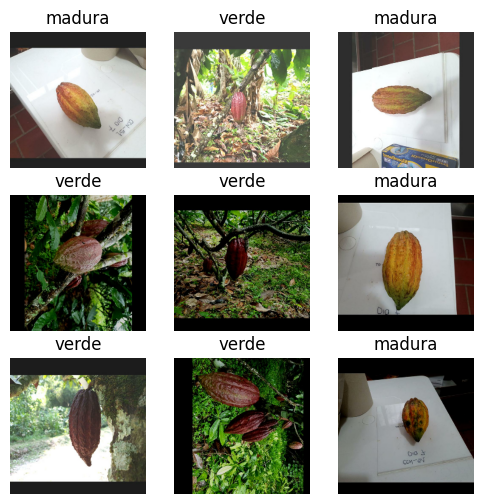

In [4]:
# Classes are madura (0), verde (1)
class_names = train_ds.class_names
print(class_names)
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1): # takes one batch of images, let's see the first 9
    #print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data Augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(.5, .2),
    ]
)

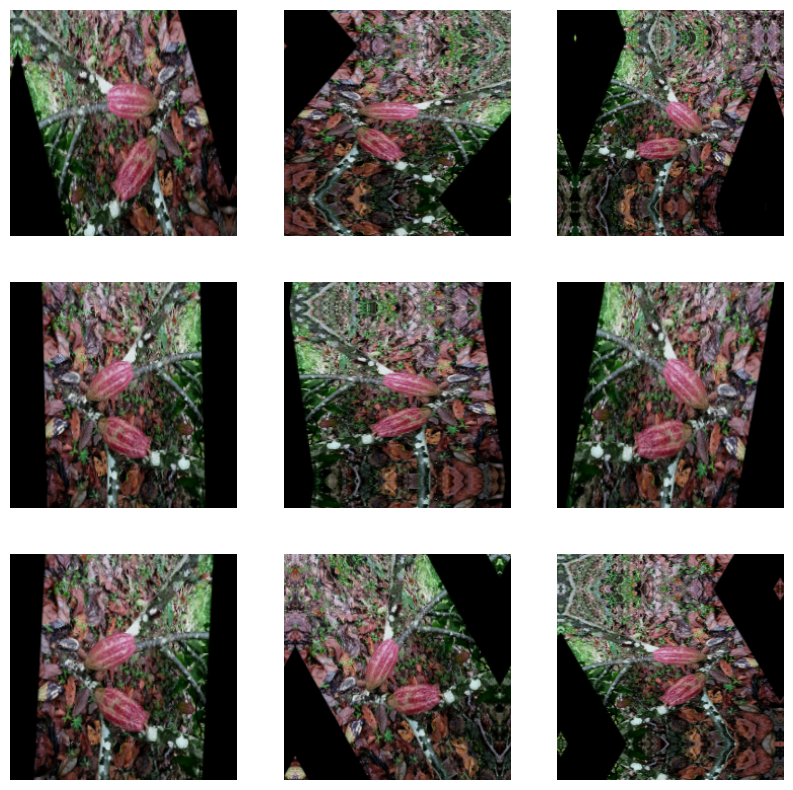

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Standardizing the data
Our image are already in a standard size (224x224), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

**Will be add to the model**

### Configure the dataset for performance
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [7]:
# GPUs are very fast for matrix computations, so we don't want the input/output of images to be a bottleneck.
# Prefetching with AUTOTUNE will help Tensorflow find the optimal way to load the images so that our GPU always has data to work on.
# More info: https://www.tensorflow.org/guide/data_performance#prefetching
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

### Build a model

In [8]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [9]:
epochs = 100
exp_name = "best_cnn_seq_v2.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(exp_name, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5),
]
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose=0,
)

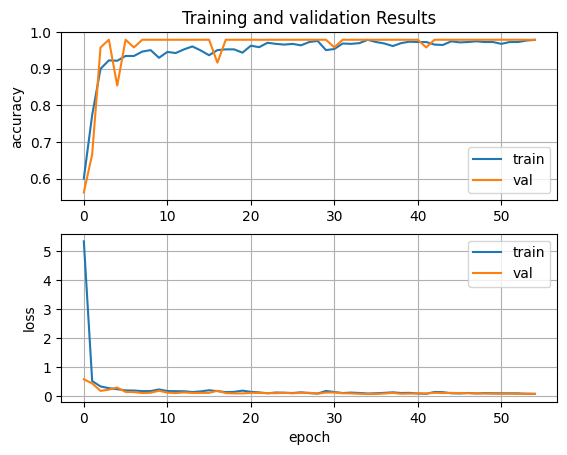

In [10]:
plt.subplot(211)
plt.title('Training and validation Results')
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')  
plt.legend(['train', 'val'], loc='lower right')
plt.grid(True)

 # summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper right')  
plt.grid(True)

plt.show()  

In [11]:
model = load_model("best_cnn_seq_v2.keras")

In [12]:
scores_train = model.evaluate(train_ds)
scores_valid = model.evaluate(val_ds)
scores_test = model.evaluate(test_ds)

3/3 [==============================] - 2s 804ms/step - loss: 0.0476 - accuracy: 0.9895


In [13]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('valid loss:', round(scores_valid[0]*100,2), '%')
print('test loss:', round(scores_test[0]*100,2), '%')

print("\n")
print('train accuracy:', round(scores_train[1]*100,2), '%')
print('valid accuracy:', round(scores_valid[1]*100,2), '%')
print('test accuracy:', round(scores_test[1]*100,2), '%')

train loss: 8.8 %
valid loss: 6.19 %
test loss: 4.76 %


train accuracy: 96.9 %
valid accuracy: 97.92 %
test accuracy: 98.95 %


## Aplicar el modelo entrenado

In [14]:
from keras.preprocessing import image

img0_Maduro = image.load_img('cacaoMaduro_2.jpg', target_size=(224, 224))
img1_Maduro = image.load_img('cacaoMaduro.jpg', target_size=(224, 224))
img2_Verde = image.load_img('cacaoVerde.jpg', target_size=(224, 224))
img3_Verde = image.load_img('cacaoVerde_2.jpg', target_size=(224, 224))

In [15]:
test_img0 = image.img_to_array(img0_Maduro)
test_img1 = image.img_to_array(img1_Maduro)
test_img2 = image.img_to_array(img2_Verde)
test_img3 = image.img_to_array(img3_Verde)

result0 = model.predict(test_img0.reshape(1,224,224,3))
result1 = model.predict(test_img1.reshape(1,224,224,3))
result2 = model.predict(test_img2.reshape(1,224,224,3))
result3 = model.predict(test_img3.reshape(1,224,224,3))

El Cacao de la imagen tiene 100.00% de probabilidad de estar Maduro y 0.00% Verde.


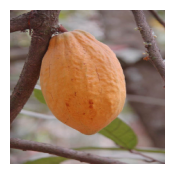

In [16]:
score_0 = float(result0[0])
print(f"El Cacao de la imagen tiene {100 * (1 - score_0):.2f}% de probabilidad de estar Maduro y {100 * score_0:.2f}% Verde.")
plt.figure(figsize=(7, 2))
plt.imshow(img0_Maduro)
plt.axis('off')
plt.show()

El Cacao de la imagen tiene 96.45% de probabilidad de estar Maduro y 3.55% Verde.


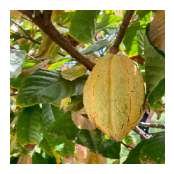

In [17]:
score_1 = float(result1[0])
print(f"El Cacao de la imagen tiene {100 * (1 - score_1):.2f}% de probabilidad de estar Maduro y {100 * score_1:.2f}% Verde.")
plt.figure(figsize=(7, 2))
plt.imshow(img1_Maduro)
plt.axis('off')
plt.show()

El Cacao de la imagen tiene 6.73% de probabilidad de estar Maduro y 93.27% Verde.


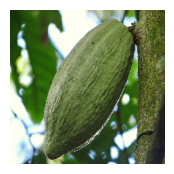

In [18]:
score_2 = float(result2[0])
print(f"El Cacao de la imagen tiene {100 * (1 - score_2):.2f}% de probabilidad de estar Maduro y {100 * score_2:.2f}% Verde.")
plt.figure(figsize=(7, 2))
plt.imshow(img2_Verde)
plt.axis('off')
plt.show()

El Cacao de la imagen tiene 0.00% de probabilidad de estar Maduro y 100.00% Verde.


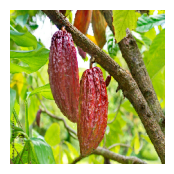

In [19]:
score_3 = float(result3[0])
print(f"El Cacao de la imagen tiene {100 * (1 - score_3):.2f}% de probabilidad de estar Maduro y {100 * score_3:.2f}% Verde.")
plt.figure(figsize=(7, 2))
plt.imshow(img3_Verde)
plt.axis('off')
plt.show()